In [1]:
#!/usr/bin/env python
 
import socket
import json
import threading
import numpy as np 
from queue import Queue
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#the data we receive over the netowrk does not neatly aling with the json objects, so je need to search the buffer for valid objects
def dynamic_json_extractor(buffer):
    
    if len(buffer) > 15000:
        #if the buffer has gotten too large (thats over 20 messages) somethin obviously has gone wrong, (mybe something misformatted?) and we should discard this
        print("Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was: ", len(buffer))
        buffer = ''
    
    timeStamp_ind = buffer.find('timeStamp')
    if timeStamp_ind > -1:
        start = buffer.rfind('{', 0, timeStamp_ind) #find last { before timstamp (json obj starts here)
        if start > -1:
            buffer = buffer[start:]  #discard everything before (cannot be full object anymore)
            #now got through the whole buffer, and see count brackets, until you find the matching closing one
            count = 0
            end_index = 0;
            success = False
            for c in buffer:
                if c == '{':
                    count += 1
                if c == '}':
                    count -= 1
                if count == 0:
                    success = True
                    break;
                end_index += 1
            if success:
                final_json = buffer[:end_index+1]
                buffer = buffer[end_index+1:]
                #print("buffer:", buffer)
                return [buffer, True, final_json]
    return[buffer, False, None]

In [3]:

def recv_ssl_data_func(ssl_to_processor_queue):
    HOST = ''
    TCP_PORT = 9001
    BUFFER_SIZE = 1024*16  

    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind((HOST, TCP_PORT))
    s.listen(1)

    decoder = json.JSONDecoder()
    buffer = ''

    #while 1: 
    conn, addr = s.accept()
    print('Connection address pos:', addr)
    while 1:
        data = conn.recv(BUFFER_SIZE)
        if not data: break
        #clear_output()
        #print("received data")
        buffer += data.decode("utf-8")

        success = True
        while success: #loop, because sometime more than one packege arrives at once
            [buffer, success, res] = dynamic_json_extractor(buffer)
            if success:
                #print("got smth")
                latest_sound_source_data = json.loads(res)
                if ssl_to_calculator_queue.qsize() > 80:           
                    for i in range(10): #q is almost full, discard some data
                        try:
                            ssl_to_calculator_queue.get(block=False)  
                        except queue.Empty:
                            pass
                ssl_to_calculator_queue.put(latest_sound_source_data) #this is blocking and thread safe


    conn.close()
    print("closed connection pos")
    

In [4]:
def angle_processor_thread_func(ssl_to_calculator_queue):
    
    #####################visualization
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.ion()
    ax.autoscale(enable=False)
    ax.set_xlim3d(-1.2,1.2)
    ax.set_ylim3d(-1.2,1.2)
    ax.set_zlim3d(-1.2,1.2)

    fig.show()
    fig.canvas.draw()
    ###########################
    
    low_pass = 0.95
    pos_est = np.array([0, 0, 0, 0])
    
    while 1:
        latest_sound_source_data = ssl_to_calculator_queue.get(block=True)
        data = []
        for i in range(len(latest_sound_source_data['src'])):
            #data will be a list of lists, containing the 4 most intense sound sources in descending order, their x,y,z postions and magnitude:
            #example: 'x': -0.267, 'y': -0.255, 'z': 0.929, 'E': 0.325           
            data.append([latest_sound_source_data['src'][i]['x'], latest_sound_source_data['src'][i]['y'], latest_sound_source_data['src'][i]['z'], latest_sound_source_data['src'][i]['E'] ])

        #for now we only deal with the most intense source (we assume only one person is speaking at a time and the rest will be reflections)
        cdata = data[0]
        pos_est = pos_est * low_pass +  np.array(cdata) * (1-low_pass)
        
        
        #####################visualization
        #visualization is super slow, so only do it, if there is no backlog
        if ssl_to_calculator_queue.qsize() < 3:
            ax.clear()
            #add big center point in front
            ax.scatter([0, pos_est[0]], [0, pos_est[1]], [0, pos_est[2]], s=[200, pos_est[3]*200], c=['blue', 'red'])
            ax.text(pos_est[0],pos_est[1],pos_est[2],  '%s' % (str(pos_est[3])), size=20)
            ax.set_xlim3d(-1.2,1.2) #dont know why, but otherwise it keeps changin them...
            ax.set_ylim3d(-1.2,1.2)
            ax.set_zlim3d(-1.2,1.2)
            fig.canvas.draw()
        ###########################
        

In [5]:
def recv_audio_data_thread_func():
    HOST = ''
    TCP_PORT = 9002
    BUFFER_SIZE = 1024*64  

    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind((HOST, TCP_PORT))
    s.listen(1)

    decoder = json.JSONDecoder()
    buffer = ''

    #while 1: 
    conn, addr = s.accept()
    print('Connection address audio:', addr)
    while 1:
        data = conn.recv(BUFFER_SIZE)
        if not data: break
        #clear_output()
        #print("received data:",  data)

    conn.close()
    print("closed connection audio")

In [6]:
ssl_to_calculator_queue = Queue(maxsize=100)


In [7]:
recv_ssl_data_thread = threading.Thread(target=recv_ssl_data_func, args=(ssl_to_calculator_queue, ))
recv_ssl_data_thread.start()

In [8]:
angle_processor_thread = threading.Thread(target=angle_processor_thread_func, args=(ssl_to_calculator_queue, ))
angle_processor_thread.start()


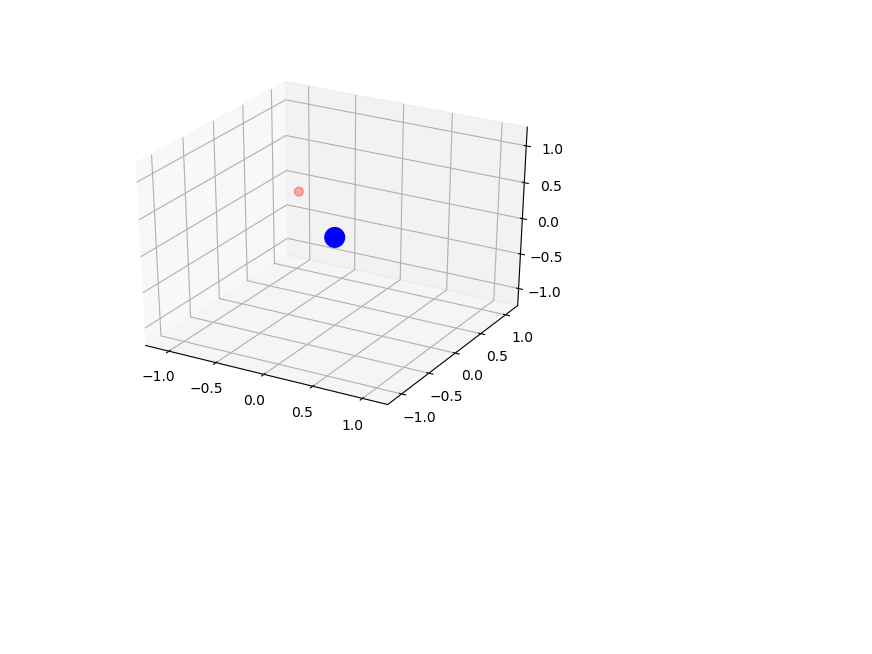

In [ ]:
recv_audio_data_thread = threading.Thread(target=recv_audio_data_thread_func)
recv_audio_data_thread.start()

In [ ]:
recv_audio_data_thread.join()#these run for ever, so this will never happen
print("recv_audio_data_thread thread has unexpectly ended (maybe odas stopped running?)")
recv_ssl_data_thread.join()#these run for ever, so this will never happen
print("recv_ssl_data thread has unexpectly ended (maybe odas stopped running?)")
angle_processor_thread.join()

Connection address pos:Connection address audio:  ('192.168.178.55', 58414)('192.168.178.55', 37856)

Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  5202
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  6348
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  5163
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  7170
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  5247
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  9318
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  6415
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  5211
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  579

Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  9906
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  5841
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  5824
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  5244
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  11636
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  11061
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  6104
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  7852
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  6137
Buffer has grown too large, something must have gone wrong, clearing buffer. Buffer size was:  730

In [ ]:
data = [[-0.16, -0.333, 0.929, 0.199], [-0.16, -0.333, 0.929, 0.199], [-0.16, -0.333, 0.929, 0.199], [-0.16, -0.333, 0.929, 0.199]]

In [ ]:
cdata = data[0]

In [ ]:
pos_est = np.array(cdata)

In [ ]:
pos_est

In [ ]:
np.column_stack([pos_est, pos_est]).transpose()